# Setup enviorment

In [ ]:
%cd ..

In [2]:
from Preprocessing.time_series_preprocessing import get_dengue_dataset, train_test_split, normalize_train_features, normalize_test_features, series_to_supervised, features_labels_set, reshape_tensor, preprocess_dataset_to_time_series

from Models.LSTM import create_model, train_model
import tensorflow as tf

from Utils.test_lstm import evaluate, plot_predictions, calculate_mean_std

import pandas as pd
import os
import numpy as np

In [3]:
""" Read Dataset:"""

embeddings = 'Embeddings/autoencoder_224_1024.csv'
labels = '../Tabular_data/dengue_tabular.csv'

# Get list of municipalities:
Municipalities = list(pd.unique(pd.read_csv(embeddings)['Municipality Code']))

""" Dataset Preprocessing:"""
train_percentage = 80
T=0
autoregressive = False
feature_range = (-1, 1)

""" Model Parameters:"""
lstm_layers=[1000, 500]
nn_layers=[250, 120, 1]
dense_acivation='relu'
recurrent_cells='LSTM'
bidirectional=False

## 1. Read Data

In [4]:
# Read dataset for top 5 municipalities
dengue_df = [get_dengue_dataset(labels_path=labels, embeddings_path=embeddings, municipality=Municipality) for Municipality in Municipalities]
type(dengue_df)

Obtaining dataframe for the city of 54001 - Cúcuta only...
Obtaining dataframe for the city of 41001 - Neiva only...
Obtaining dataframe for the city of 5001 - Medellín only...
Obtaining dataframe for the city of 50001 - Villavicencio only...
Obtaining dataframe for the city of 68001 - Bucaramanga only...
Obtaining dataframe for the city of 8001 - Barranquilla only...
Obtaining dataframe for the city of 23001 - Montería only...
Obtaining dataframe for the city of 76001 - Cali only...
Obtaining dataframe for the city of 73001 - Ibagué only...
Obtaining dataframe for the city of 5360 - Itagüí only...


list

## 2. Preprocessing

### Train Test split

In [5]:
train_df = dengue_df[:int(len(dengue_df)*(train_percentage/100))]
Municipalities_train = Municipalities[:int(len(dengue_df)*(train_percentage/100))]
test_df = dengue_df[int(len(dengue_df)*(train_percentage/100)):]
Municipalities_test = Municipalities[int(len(dengue_df)*(train_percentage/100)):]
#test_df

### Normalize features

In [6]:
# Merge:
train_df = pd.concat(train_df, keys=Municipalities_train)
test_df = pd.concat(test_df, keys=Municipalities_test)

In [7]:
# Scale train:
train_df, scalers = normalize_train_features(train_df, feature_range=feature_range)
train_df = [train_df[train_df.index.get_level_values(0) == municipality] for municipality in Municipalities_train]

#print(f'The scalers are: {scalers}')

train_df[1].head()

0    1    2    3    4    5    6    7    8    9  ...  1015  \
41001 201546 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  -1.0   
      201547 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  -1.0   
      201548 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  -1.0   
      201549 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  -1.0   
      201550 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0  ...  -1.0   

              1016  1017  1018  1019  1020  1021  1022  1023    Labels  
41001 201546  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0 -0.861740  
      201547  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0 -0.854589  
      201548  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0 -0.856973  
      201549  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0 -0.856973  
      201550  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0  -1.0 -0.823600  

[5 rows x 1025 columns]

In [8]:
# Scale test:
test_df = normalize_test_features(test_df, scalers=scalers)
test_df = [test_df[test_df.index.get_level_values(0) == municipality] for municipality in Municipalities_test]

test_df[1].head()

0        1    2    3    4    5    6    7         8    9  ...  \
5360 201546 -1.0 -1.00000 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.000000 -1.0  ...   
     201547 -1.0 -1.00000 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -0.485468 -1.0  ...   
     201548 -1.0 -1.00000 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.000000 -1.0  ...   
     201549 -1.0 -0.14592 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -0.706597 -1.0  ...   
     201550 -1.0 -1.00000 -1.0 -1.0 -1.0 -1.0 -1.0 -1.0 -1.000000 -1.0  ...   

             1015      1016  1017  1018     1019  1020  1021  1022  1023  \
5360 201546  -1.0 -1.000000  -1.0  -1.0 -1.00000  -1.0  -1.0  -1.0  -1.0   
     201547  -1.0 -1.000000  -1.0  -1.0 -0.87153  -1.0  -1.0  -1.0  -1.0   
     201548  -1.0 -1.000000  -1.0  -1.0 -1.00000  -1.0  -1.0  -1.0  -1.0   
     201549  -1.0  0.390491  -1.0  -1.0 -1.00000  -1.0  -1.0  -1.0  -1.0   
     201550  -1.0 -1.000000  -1.0  -1.0 -1.00000  -1.0  -1.0  -1.0  -1.0   

               Labels  
5360 201546 -0.990465  
     201547 -0.969011  
     201548 -0.995232  
     201549 -0.997616  
     201550 -0.971395  

[5 rows x 1025 columns]

### Prepare data for time series supervised learning (function to create sliding window)

In [9]:
# frame as supervised learning
train = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in train_df]
test = [series_to_supervised(df, n_in=T, autoregressive=autoregressive) for df in test_df]

train[1].shape

(163, 1025)

### Merge train data

In [10]:
# Merge:
train = pd.concat(train, keys=Municipalities_train)
test = pd.concat(test, keys=Municipalities_test)

### Features and Labels Set

In [11]:
# Train features and labels set
print('Train:')
train_X, train_y, n_features = features_labels_set(timeseries_data=train, original_df=dengue_df[0], autoregressive=autoregressive)

# Test features and labels set
print('Test:')
test_X, test_y, n_features = features_labels_set(timeseries_data=test, original_df=dengue_df[0], autoregressive=autoregressive)

Train:
The shape of the features is (1304, 1024)
The shape of the labels is (1304, 1)
Test:
The shape of the features is (326, 1024)
The shape of the labels is (326, 1)


In [12]:
# reshape input to be 3D [samples, timesteps, features]
if T != 0:
    train_X, test_X = reshape_tensor(train_X, test_X, n_features, T, autoregressive)

# 2. Model

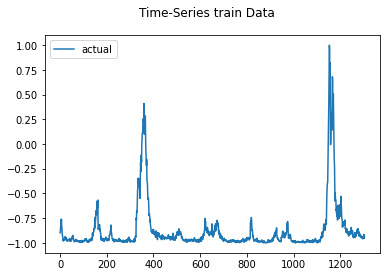

2023-03-04 23:51:34.289767: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-04 23:51:34.289850: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-04 23:51:34.289885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f7bdfccc75e): /proc/driver/nvidia/version does not exist
2023-03-04 23:51:34.290146: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-04 23:51:34.377046: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] 

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 35.377
Test sMAPE: 133.653
Test RMSE: 51.149
{'mae': 35.37684987366565, 'smape': 133.6532130152564, 'rmse': 51.14875539219299}


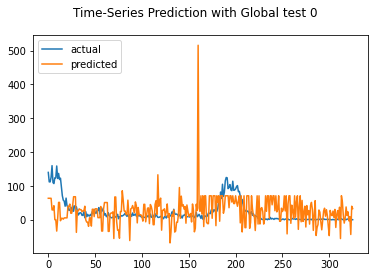

Test MAE: 70.196
Test sMAPE: 138.042
Test RMSE: 102.959
{'mae': 70.19585896361093, 'smape': 138.04170010431937, 'rmse': 102.95945075368782}


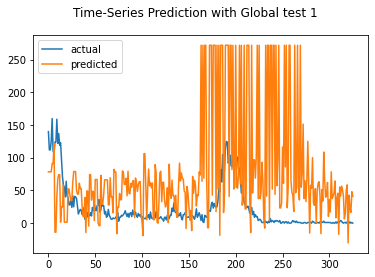

Test MAE: 84.535
Test sMAPE: 145.136
Test RMSE: 121.282
{'mae': 84.53486630594803, 'smape': 145.1364573088294, 'rmse': 121.28233810245001}


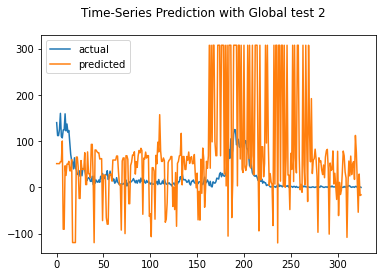

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 58.675
Test sMAPE: 132.287
Test RMSE: 70.226
{'mae': 58.67484155023025, 'smape': 132.28679294251697, 'rmse': 70.22601736728825}


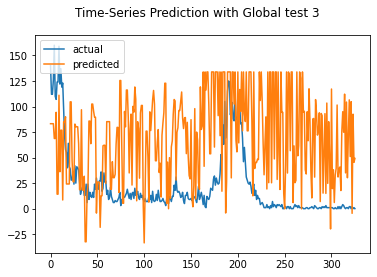

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 52.388
Test sMAPE: 143.573
Test RMSE: 65.273
{'mae': 52.387810961600465, 'smape': 143.57299746665223, 'rmse': 65.27260088088242}


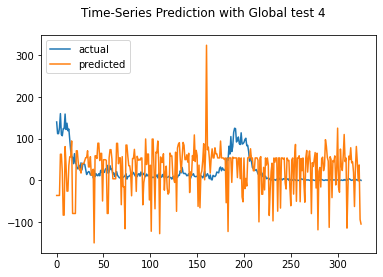

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 41.740
Test sMAPE: 133.531
Test RMSE: 52.476
{'mae': 41.740071893104016, 'smape': 133.53130757655396, 'rmse': 52.47609971837796}


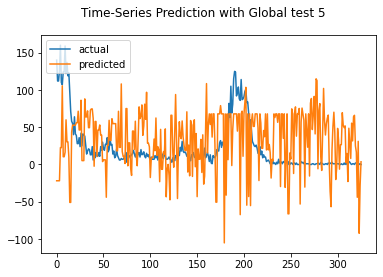

Test MAE: 49.828
Test sMAPE: 131.378
Test RMSE: 56.132
{'mae': 49.82775612111472, 'smape': 131.3782469199818, 'rmse': 56.132255164804036}


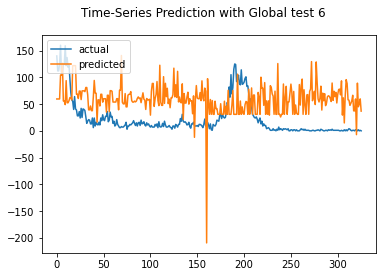

Test MAE: 75.351
Test sMAPE: 139.642
Test RMSE: 97.539
{'mae': 75.35127474961837, 'smape': 139.64181292944178, 'rmse': 97.53936891984787}


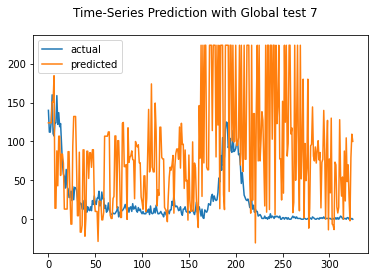

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 50.438
Test sMAPE: 151.794
Test RMSE: 74.741
{'mae': 50.43756875560327, 'smape': 151.79356409140019, 'rmse': 74.74059911895225}


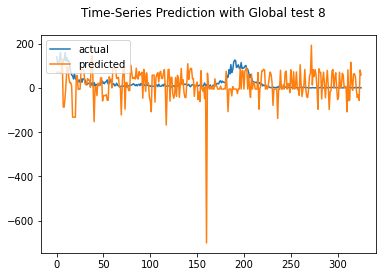

Test MAE: 109.087
Test sMAPE: 149.303
Test RMSE: 123.948
{'mae': 109.0874167337008, 'smape': 149.3026891339014, 'rmse': 123.94791024585585}


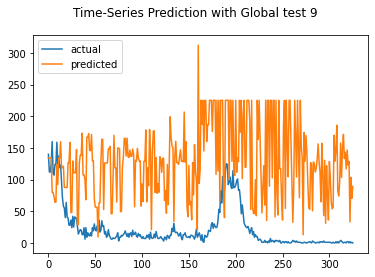

Restoring model weights from the end of the best epoch.
Epoch 00040: early stopping
Test MAE: 47.823
Test sMAPE: 134.532
Test RMSE: 60.184
{'mae': 47.82336249819563, 'smape': 134.53183197249496, 'rmse': 60.18385246626083}


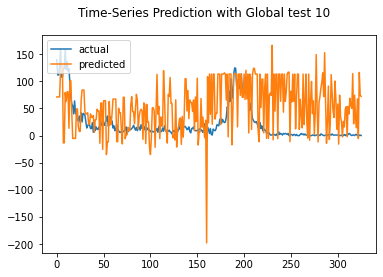

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 82.970
Test sMAPE: 149.742
Test RMSE: 104.187
{'mae': 82.96981908134156, 'smape': 149.7424337497647, 'rmse': 104.18696910416641}


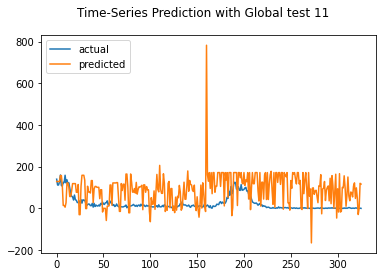

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 46.230
Test sMAPE: 136.346
Test RMSE: 68.464
{'mae': 46.23007795232937, 'smape': 136.34550287480724, 'rmse': 68.46384968643594}


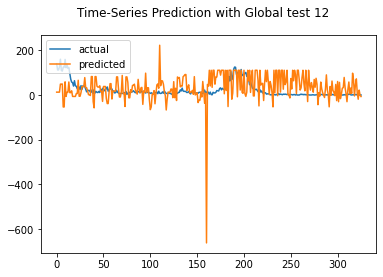

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 39.396
Test sMAPE: 137.043
Test RMSE: 52.585
{'mae': 39.39604726040656, 'smape': 137.0429491550662, 'rmse': 52.585189731925894}


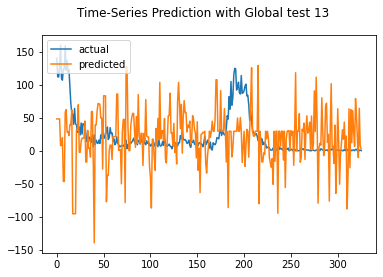

Test MAE: 59.483
Test sMAPE: 129.791
Test RMSE: 81.321
{'mae': 59.48332304073258, 'smape': 129.79133771715684, 'rmse': 81.3205454090781}


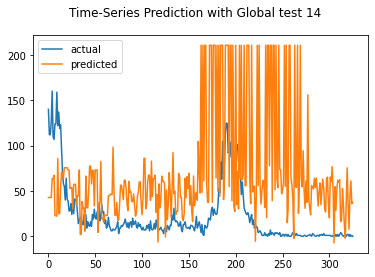

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 38.258
Test sMAPE: 135.320
Test RMSE: 48.511
{'mae': 38.257595625391765, 'smape': 135.31991620536013, 'rmse': 48.51063463579731}


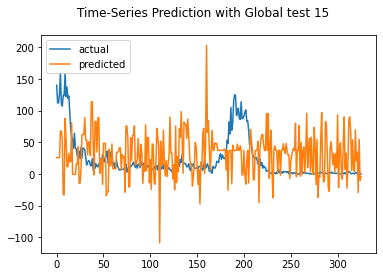

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 52.050
Test sMAPE: 139.538
Test RMSE: 69.501
{'mae': 52.049822825229974, 'smape': 139.53761568177637, 'rmse': 69.50053094354176}


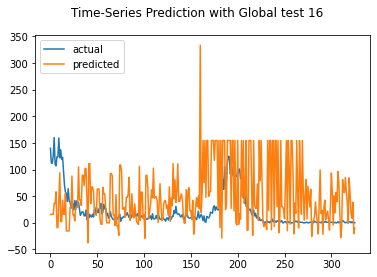

Test MAE: 50.803
Test sMAPE: 138.237
Test RMSE: 61.360
{'mae': 50.80276533522489, 'smape': 138.23667998368532, 'rmse': 61.3603137255016}


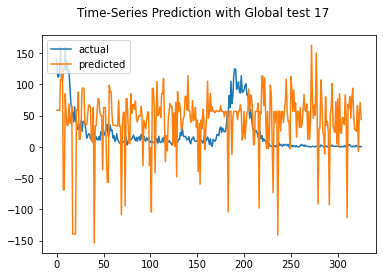

Test MAE: 57.580
Test sMAPE: 134.434
Test RMSE: 65.330
{'mae': 57.5797200963541, 'smape': 134.4341447559825, 'rmse': 65.32978264384552}


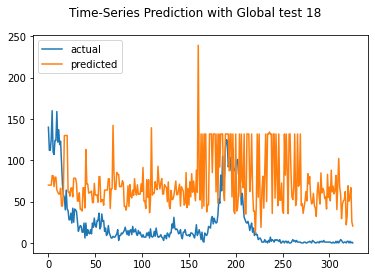

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 46.979
Test sMAPE: 135.715
Test RMSE: 58.224
{'mae': 46.97857257175299, 'smape': 135.7147169981919, 'rmse': 58.223990090686065}


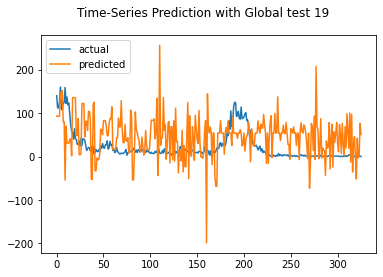

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 58.031
Test sMAPE: 136.296
Test RMSE: 73.047
{'mae': 58.031224660346844, 'smape': 136.29586112134916, 'rmse': 73.04660769465973}


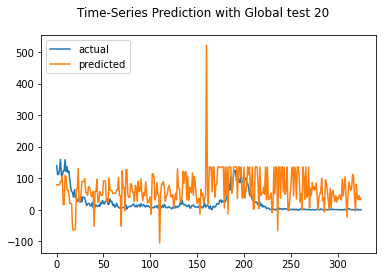

Test MAE: 63.277
Test sMAPE: 149.034
Test RMSE: 72.633
{'mae': 63.27712369111418, 'smape': 149.0341796825101, 'rmse': 72.63302488288772}


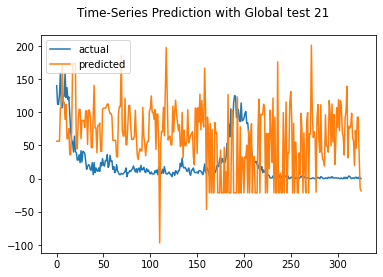

Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
Test MAE: 75.798
Test sMAPE: 161.681
Test RMSE: 99.069
{'mae': 75.7975509501308, 'smape': 161.6811251098822, 'rmse': 99.06903387395032}


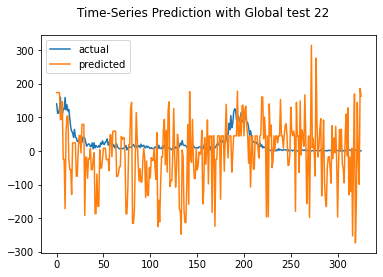

Test MAE: 52.064
Test sMAPE: 130.964
Test RMSE: 74.067
{'mae': 52.06441196360471, 'smape': 130.96400507729535, 'rmse': 74.06670306607093}


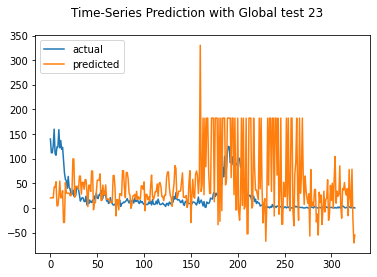

Restoring model weights from the end of the best epoch.
Epoch 00048: early stopping
Test MAE: 58.134
Test sMAPE: 146.923
Test RMSE: 69.213
{'mae': 58.134299848708636, 'smape': 146.9233619171608, 'rmse': 69.21308049365916}


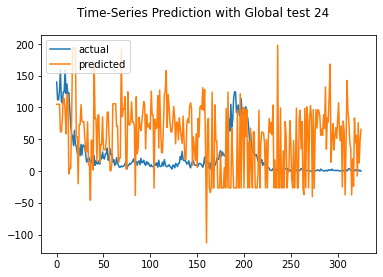

Test MAE: 66.804
Test sMAPE: 139.162
Test RMSE: 78.809
{'mae': 66.80375006959483, 'smape': 139.16215053816342, 'rmse': 78.80905825706184}


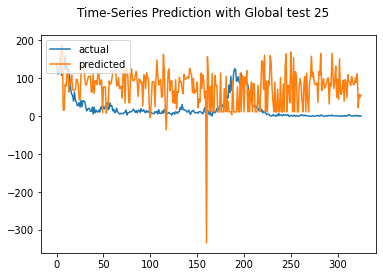

Test MAE: 102.155
Test sMAPE: 149.103
Test RMSE: 149.795
{'mae': 102.15508471721886, 'smape': 149.10343996172838, 'rmse': 149.79503936534914}


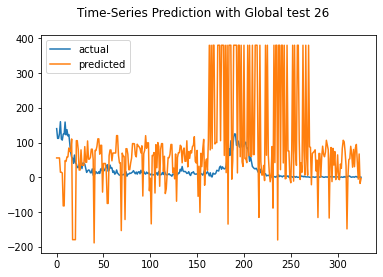

Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
Test MAE: 42.914
Test sMAPE: 125.412
Test RMSE: 52.860
{'mae': 42.913540620562486, 'smape': 125.41156953723764, 'rmse': 52.86008280656159}


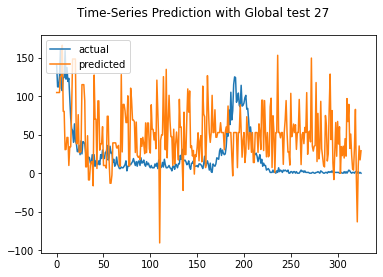

Test MAE: 89.758
Test sMAPE: 157.867
Test RMSE: 120.323
{'mae': 89.75817676373055, 'smape': 157.8674942476249, 'rmse': 120.32282409357786}


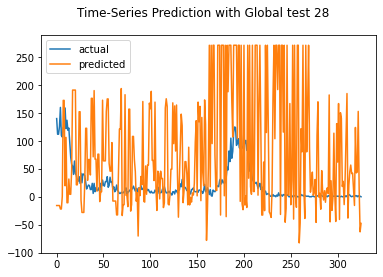

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 33.758
Test sMAPE: 125.833
Test RMSE: 45.905
{'mae': 33.75814823376621, 'smape': 125.83327694835953, 'rmse': 45.9052036004968}


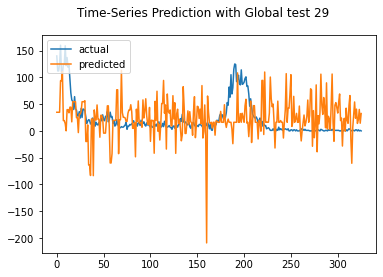

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 39.906
Test sMAPE: 143.983
Test RMSE: 51.460
{'mae': 39.90561656388768, 'smape': 143.98322710057175, 'rmse': 51.459531059436635}


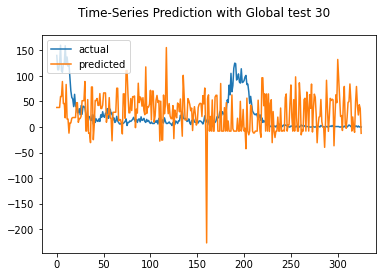

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 48.801
Test sMAPE: 130.285
Test RMSE: 60.367
{'mae': 48.80121841441634, 'smape': 130.28508043099473, 'rmse': 60.36688773838369}


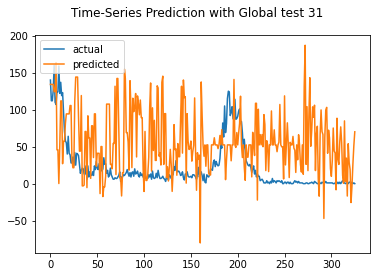

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 55.337
Test sMAPE: 148.474
Test RMSE: 71.494
{'mae': 55.33658895975242, 'smape': 148.47379314853686, 'rmse': 71.49389456093782}


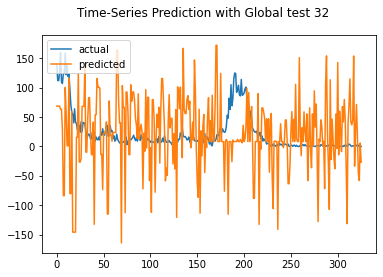

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 49.387
Test sMAPE: 139.694
Test RMSE: 68.901
{'mae': 49.38660236845718, 'smape': 139.6939159065946, 'rmse': 68.9010546571561}


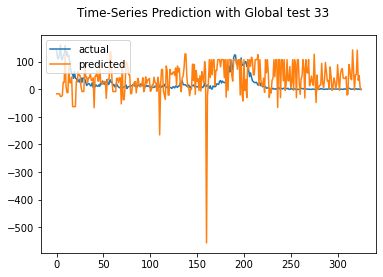

Test MAE: 64.008
Test sMAPE: 152.651
Test RMSE: 74.211
{'mae': 64.00827325231458, 'smape': 152.65083594947663, 'rmse': 74.21061072527523}


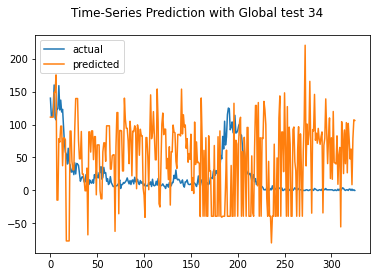

Test MAE: 65.198
Test sMAPE: 138.010
Test RMSE: 74.656
{'mae': 65.19765762024862, 'smape': 138.00978085789933, 'rmse': 74.65572921868682}


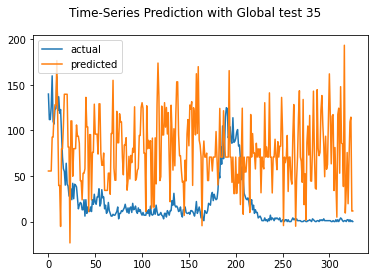

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 51.322
Test sMAPE: 128.413
Test RMSE: 64.158
{'mae': 51.32185841008929, 'smape': 128.41315184085616, 'rmse': 64.15801482443523}


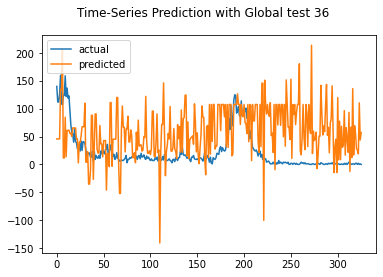

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 44.131
Test sMAPE: 134.854
Test RMSE: 54.460
{'mae': 44.131005218241114, 'smape': 134.85400500409867, 'rmse': 54.460411910303165}


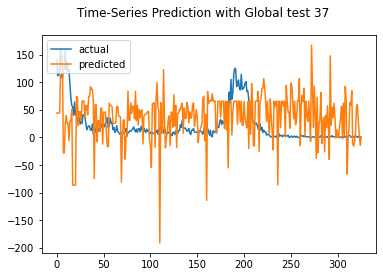

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 46.476
Test sMAPE: 140.002
Test RMSE: 56.753
{'mae': 46.4762166546532, 'smape': 140.0022428612928, 'rmse': 56.75263327700317}


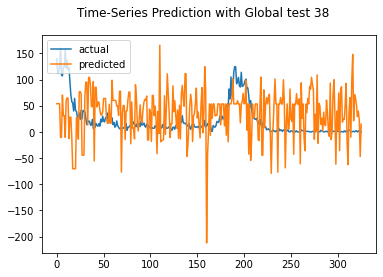

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 35.303
Test sMAPE: 135.850
Test RMSE: 47.740
{'mae': 35.30294082208645, 'smape': 135.85002288482713, 'rmse': 47.74039117547888}


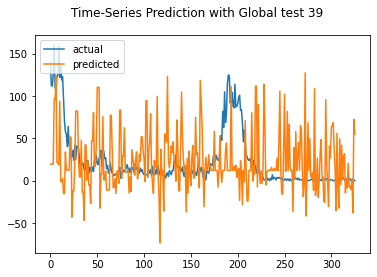

Test MAE: 66.967
Test sMAPE: 137.573
Test RMSE: 80.280
{'mae': 66.96720785396231, 'smape': 137.57307117360767, 'rmse': 80.27966215563859}


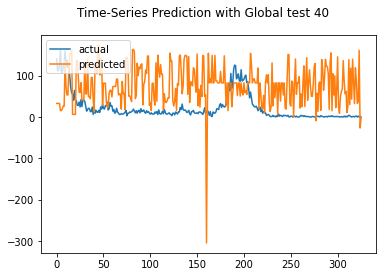

Test MAE: 99.911
Test sMAPE: 148.617
Test RMSE: 110.319
{'mae': 99.91070747960565, 'smape': 148.61688998143433, 'rmse': 110.3194754875367}


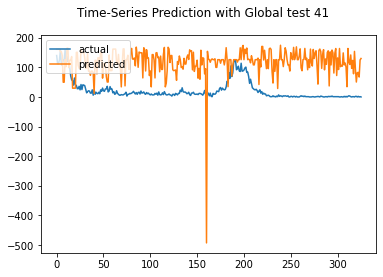

Test MAE: 84.328
Test sMAPE: 143.217
Test RMSE: 112.663
{'mae': 84.32770067544803, 'smape': 143.217026794468, 'rmse': 112.66329992488366}


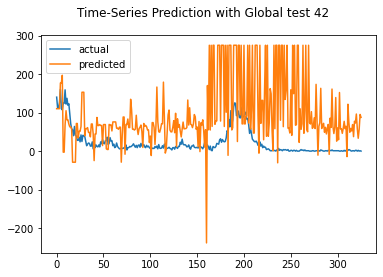

Test MAE: 68.896
Test sMAPE: 140.139
Test RMSE: 79.850
{'mae': 68.89641347399518, 'smape': 140.13902499615003, 'rmse': 79.84977622923829}


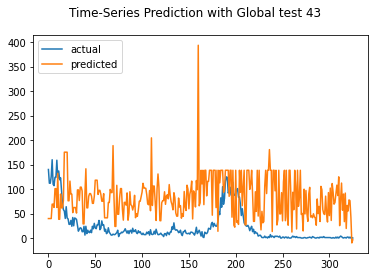

Test MAE: 47.309
Test sMAPE: 129.209
Test RMSE: 62.100
{'mae': 47.30893004827338, 'smape': 129.20904260892334, 'rmse': 62.09977781832736}


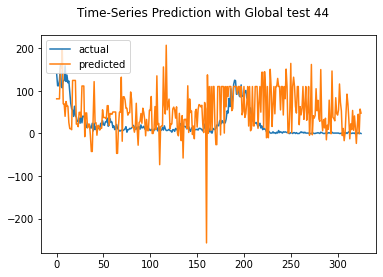

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 53.882
Test sMAPE: 140.554
Test RMSE: 67.121
{'mae': 53.88182249555558, 'smape': 140.55397149119744, 'rmse': 67.12081842385622}


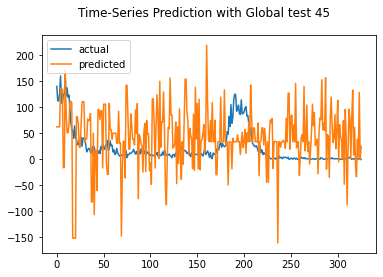

Test MAE: 75.754
Test sMAPE: 139.132
Test RMSE: 104.705
{'mae': 75.75436722446074, 'smape': 139.1322610392495, 'rmse': 104.70497083512527}


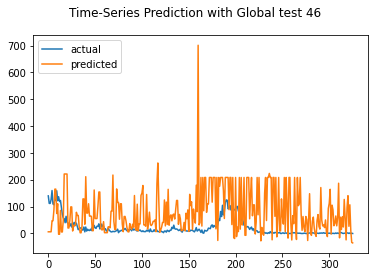

Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
Test MAE: 53.153
Test sMAPE: 155.559
Test RMSE: 74.515
{'mae': 53.15281424639415, 'smape': 155.5589232685766, 'rmse': 74.51549604013512}


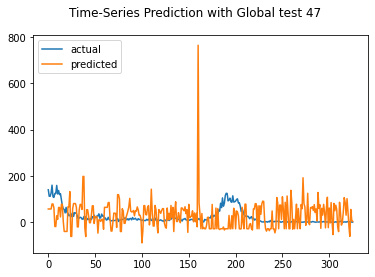

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 54.152
Test sMAPE: 140.309
Test RMSE: 66.011
{'mae': 54.15164861412136, 'smape': 140.30917445450834, 'rmse': 66.01104870600643}


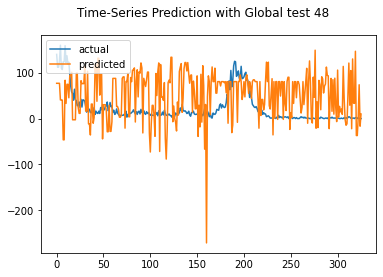

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 41.613
Test sMAPE: 125.963
Test RMSE: 50.632
{'mae': 41.612810181693796, 'smape': 125.96261889581035, 'rmse': 50.631823613903336}


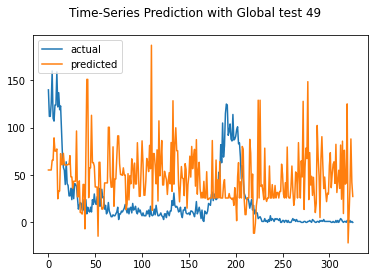

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 49.387
Test sMAPE: 139.967
Test RMSE: 65.961
{'mae': 49.38722601990027, 'smape': 139.96669504619004, 'rmse': 65.96124455938815}


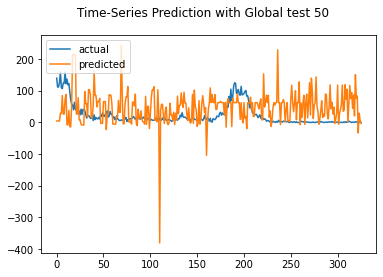

Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping
Test MAE: 90.448
Test sMAPE: 170.585
Test RMSE: 114.504
{'mae': 90.44812288770646, 'smape': 170.58494626850737, 'rmse': 114.50390718416826}


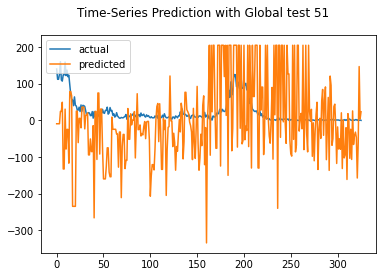

Test MAE: 65.283
Test sMAPE: 130.053
Test RMSE: 80.282
{'mae': 65.28312459313797, 'smape': 130.0531177824576, 'rmse': 80.28242976249409}


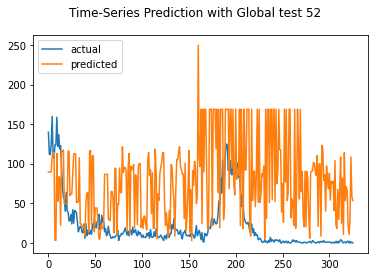

Restoring model weights from the end of the best epoch.
Epoch 00034: early stopping
Test MAE: 47.830
Test sMAPE: 132.285
Test RMSE: 60.424
{'mae': 47.82987281085889, 'smape': 132.28480522207477, 'rmse': 60.42395175272456}


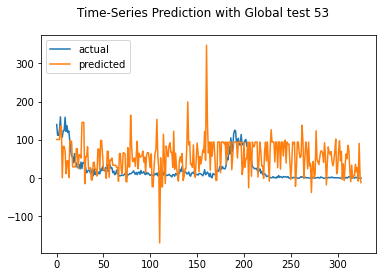

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 52.325
Test sMAPE: 138.026
Test RMSE: 63.481
{'mae': 52.32493100722143, 'smape': 138.02575005375155, 'rmse': 63.481344600056545}


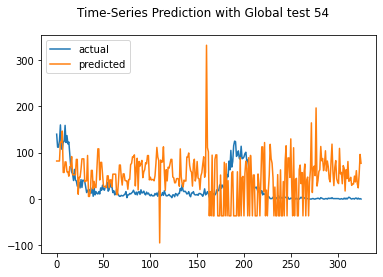

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 38.948
Test sMAPE: 134.298
Test RMSE: 51.808
{'mae': 38.94794790062802, 'smape': 134.29829925234475, 'rmse': 51.80767123709562}


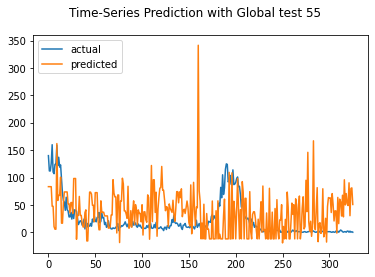

Test MAE: 71.742
Test sMAPE: 146.590
Test RMSE: 92.092
{'mae': 71.7420200920361, 'smape': 146.59040799021844, 'rmse': 92.09231465336937}


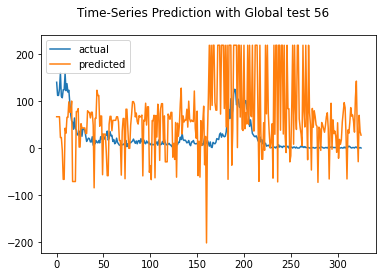

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 40.470
Test sMAPE: 132.667
Test RMSE: 54.598
{'mae': 40.46951535947484, 'smape': 132.66729543995032, 'rmse': 54.598260352599006}


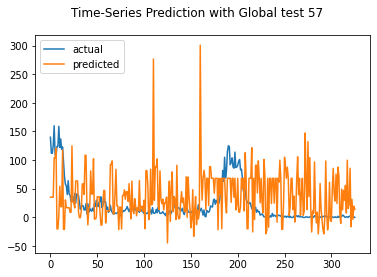

Restoring model weights from the end of the best epoch.
Epoch 00037: early stopping
Test MAE: 54.406
Test sMAPE: 140.807
Test RMSE: 70.526
{'mae': 54.40619667102954, 'smape': 140.80660654750875, 'rmse': 70.52591454438196}


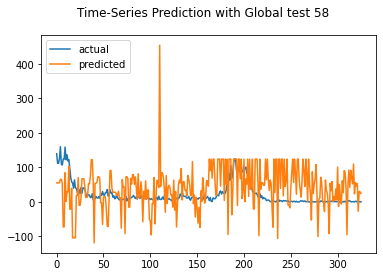

Test MAE: 49.853
Test sMAPE: 135.113
Test RMSE: 75.446
{'mae': 49.853425204753876, 'smape': 135.11296426420083, 'rmse': 75.4462480856936}


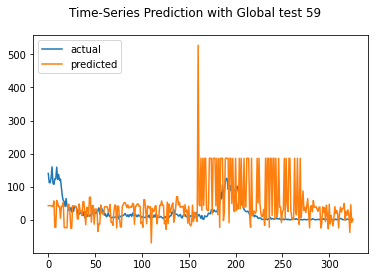

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 54.053
Test sMAPE: 132.327
Test RMSE: 70.319
{'mae': 54.05346614853736, 'smape': 132.3271442622093, 'rmse': 70.31887957552954}


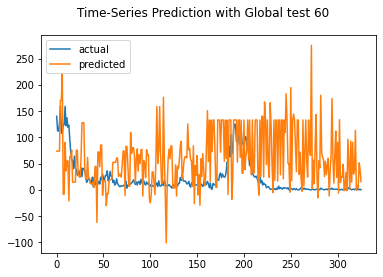

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 50.285
Test sMAPE: 129.112
Test RMSE: 61.521
{'mae': 50.28530046746043, 'smape': 129.112313991187, 'rmse': 61.52141991018358}


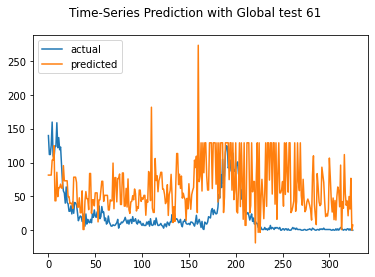

Test MAE: 64.031
Test sMAPE: 138.677
Test RMSE: 74.834
{'mae': 64.03123649790243, 'smape': 138.67719595374263, 'rmse': 74.83397634310268}


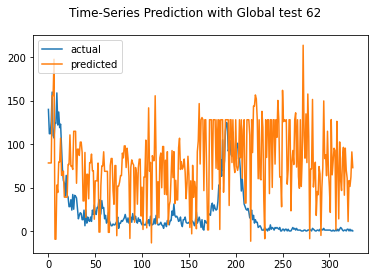

Restoring model weights from the end of the best epoch.
Epoch 00029: early stopping
Test MAE: 59.160
Test sMAPE: 141.197
Test RMSE: 77.408
{'mae': 59.15964366614453, 'smape': 141.19689996082292, 'rmse': 77.40750456495167}


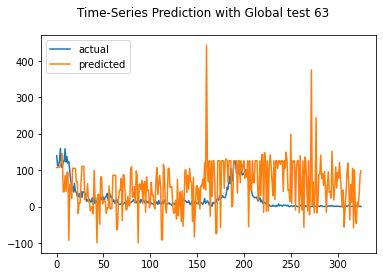

Test MAE: 76.021
Test sMAPE: 139.592
Test RMSE: 87.770
{'mae': 76.0211791783754, 'smape': 139.59157668993694, 'rmse': 87.77020106007026}


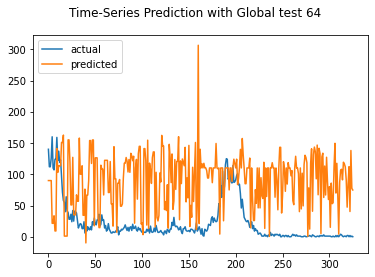

Test MAE: 104.929
Test sMAPE: 145.222
Test RMSE: 126.234
{'mae': 104.92938458663555, 'smape': 145.2221839978332, 'rmse': 126.23380698291389}


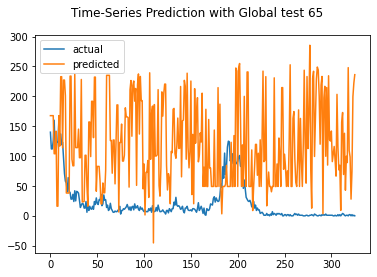

Restoring model weights from the end of the best epoch.
Epoch 00027: early stopping
Test MAE: 91.159
Test sMAPE: 155.834
Test RMSE: 107.301
{'mae': 91.15942787465873, 'smape': 155.8344749096489, 'rmse': 107.30135974230298}


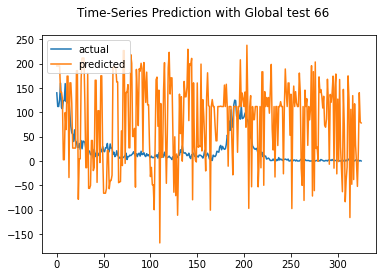

Test MAE: 69.227
Test sMAPE: 142.893
Test RMSE: 86.030
{'mae': 69.22703554220726, 'smape': 142.89295316948048, 'rmse': 86.03043268706526}


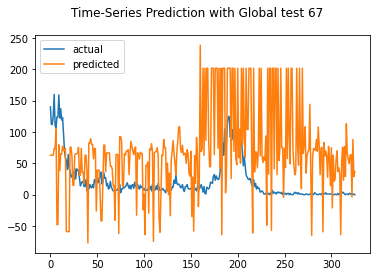

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 44.615
Test sMAPE: 131.045
Test RMSE: 57.222
{'mae': 44.614951427728855, 'smape': 131.0451019451378, 'rmse': 57.22223441789839}


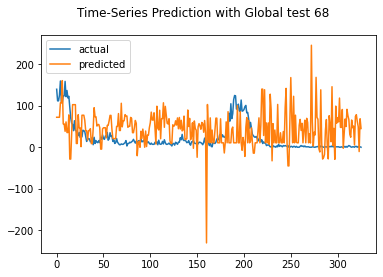

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 54.067
Test sMAPE: 143.259
Test RMSE: 65.478
{'mae': 54.0668874540212, 'smape': 143.2592163905257, 'rmse': 65.4781903457114}


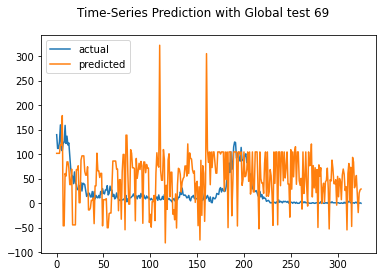

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 43.727
Test sMAPE: 137.967
Test RMSE: 52.240
{'mae': 43.72662607402158, 'smape': 137.9671163951109, 'rmse': 52.239765707069246}


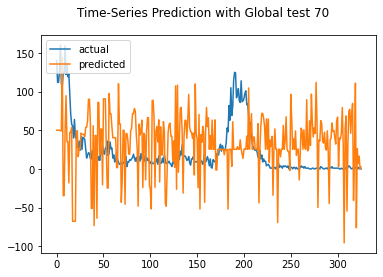

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 44.398
Test sMAPE: 131.425
Test RMSE: 53.005
{'mae': 44.397983356121856, 'smape': 131.42485550615413, 'rmse': 53.00534634458213}


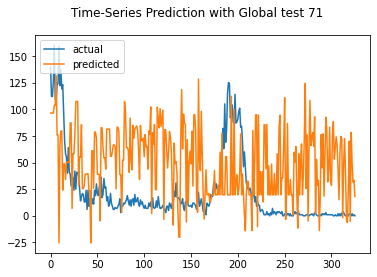

Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
Test MAE: 65.751
Test sMAPE: 154.155
Test RMSE: 78.032
{'mae': 65.75134104654833, 'smape': 154.1550924472366, 'rmse': 78.03240560159018}


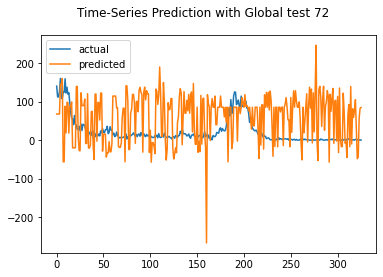

Test MAE: 35.639
Test sMAPE: 123.845
Test RMSE: 54.672
{'mae': 35.63876489335043, 'smape': 123.84534891287267, 'rmse': 54.67214507321848}


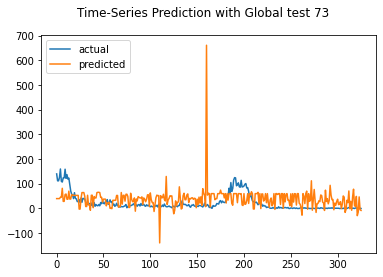

Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
Test MAE: 49.051
Test sMAPE: 133.837
Test RMSE: 62.525
{'mae': 49.05141193625386, 'smape': 133.83707530524984, 'rmse': 62.524583015452734}


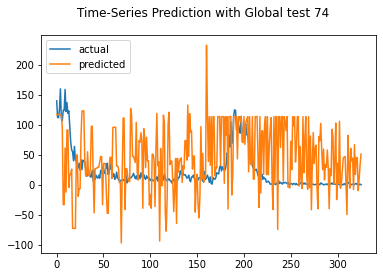

Restoring model weights from the end of the best epoch.
Epoch 00049: early stopping
Test MAE: 46.026
Test sMAPE: 131.040
Test RMSE: 53.610
{'mae': 46.0264671536311, 'smape': 131.03984110535194, 'rmse': 53.60980440178187}


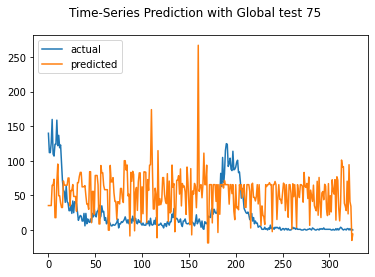

Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
Test MAE: 37.890
Test sMAPE: 134.389
Test RMSE: 45.930
{'mae': 37.890418673768366, 'smape': 134.38902713484927, 'rmse': 45.93017542921901}


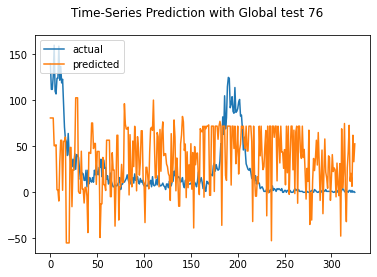

Restoring model weights from the end of the best epoch.
Epoch 00041: early stopping
Test MAE: 39.669
Test sMAPE: 121.115
Test RMSE: 51.427
{'mae': 39.66934894875515, 'smape': 121.114891161209, 'rmse': 51.42656436420213}


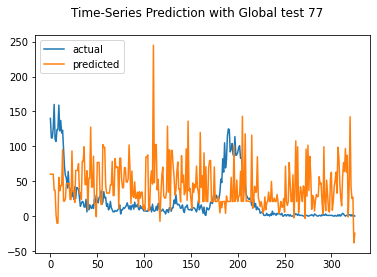

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 38.162
Test sMAPE: 124.824
Test RMSE: 48.841
{'mae': 38.161564170948566, 'smape': 124.8235054189614, 'rmse': 48.841105908401964}


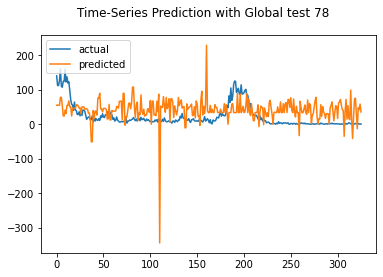

Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
Test MAE: 45.288
Test sMAPE: 134.386
Test RMSE: 58.381
{'mae': 45.28835331717152, 'smape': 134.38646219004553, 'rmse': 58.380849071780645}


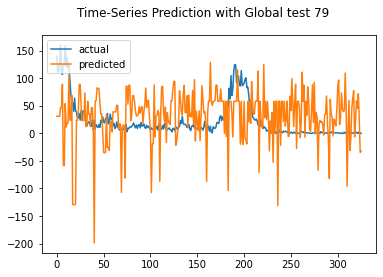

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 54.260
Test sMAPE: 132.702
Test RMSE: 78.412
{'mae': 54.260350416591564, 'smape': 132.70184435772842, 'rmse': 78.41239336546931}


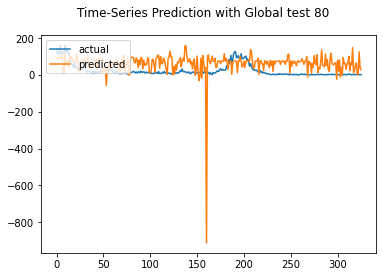

Test MAE: 82.258
Test sMAPE: 141.184
Test RMSE: 125.678
{'mae': 82.25835568389279, 'smape': 141.18438934753905, 'rmse': 125.67797111476217}


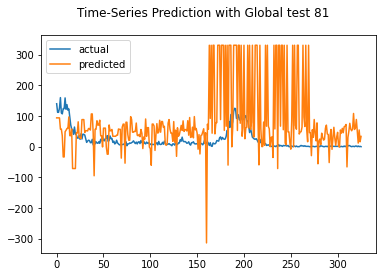

Restoring model weights from the end of the best epoch.
Epoch 00045: early stopping
Test MAE: 47.587
Test sMAPE: 141.338
Test RMSE: 59.771
{'mae': 47.58671764956296, 'smape': 141.33760382348873, 'rmse': 59.770537539869835}


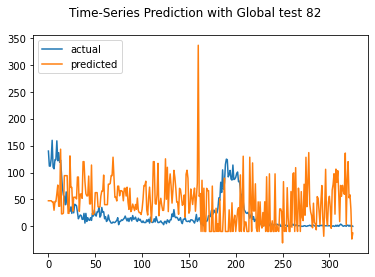

Test MAE: 76.390
Test sMAPE: 140.656
Test RMSE: 85.411
{'mae': 76.38970886710231, 'smape': 140.65568053788374, 'rmse': 85.41071036773747}


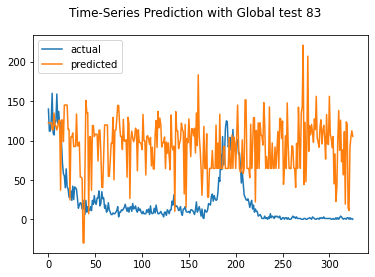

Test MAE: 71.809
Test sMAPE: 146.092
Test RMSE: 82.886
{'mae': 71.80941314273085, 'smape': 146.09220217681377, 'rmse': 82.88626717578776}


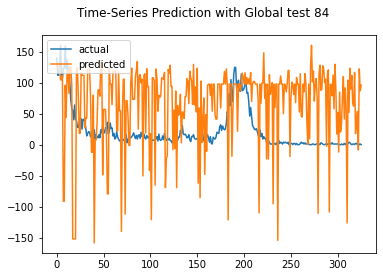

Restoring model weights from the end of the best epoch.
Epoch 00030: early stopping
Test MAE: 35.176
Test sMAPE: 141.355
Test RMSE: 50.827
{'mae': 35.17575307309262, 'smape': 141.35473292461506, 'rmse': 50.82693923528124}


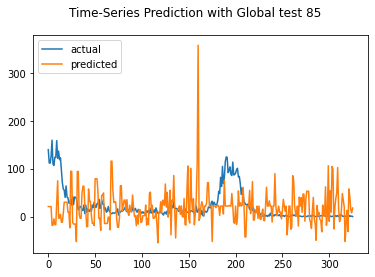

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 37.766
Test sMAPE: 125.730
Test RMSE: 48.846
{'mae': 37.766295271965625, 'smape': 125.73038659569744, 'rmse': 48.84639620906709}


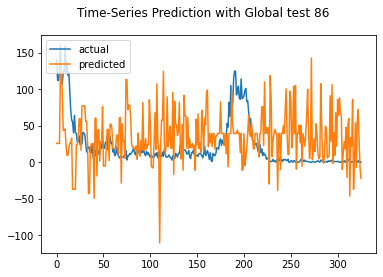

Restoring model weights from the end of the best epoch.
Epoch 00043: early stopping
Test MAE: 42.784
Test sMAPE: 138.865
Test RMSE: 57.742
{'mae': 42.78388620007989, 'smape': 138.8649245014269, 'rmse': 57.74227506522202}


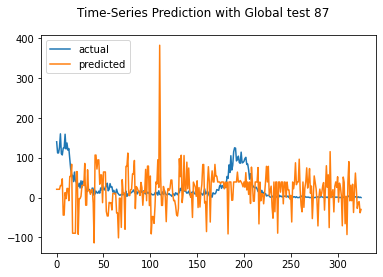

Restoring model weights from the end of the best epoch.
Epoch 00047: early stopping
Test MAE: 59.575
Test sMAPE: 138.787
Test RMSE: 73.836
{'mae': 59.574534992407436, 'smape': 138.78703607287173, 'rmse': 73.83623138195838}


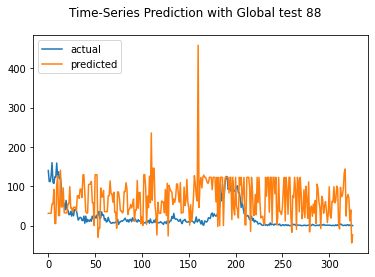

Test MAE: 67.331
Test sMAPE: 147.586
Test RMSE: 105.681
{'mae': 67.33104888244641, 'smape': 147.58552734175822, 'rmse': 105.68106756935833}


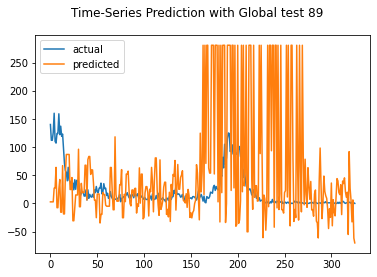

Restoring model weights from the end of the best epoch.
Epoch 00032: early stopping
Test MAE: 73.261
Test sMAPE: 136.905
Test RMSE: 100.626
{'mae': 73.26058632501064, 'smape': 136.90491226404384, 'rmse': 100.62554614830849}


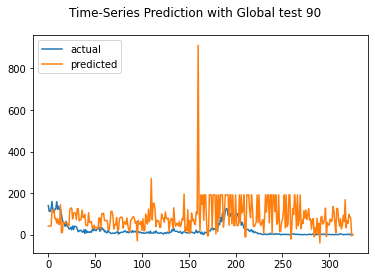

Restoring model weights from the end of the best epoch.
Epoch 00046: early stopping
Test MAE: 32.961
Test sMAPE: 120.881
Test RMSE: 43.863
{'mae': 32.96129308448979, 'smape': 120.88066867733173, 'rmse': 43.86305620443392}


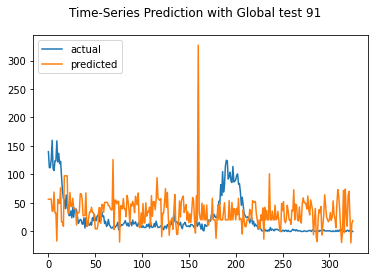

Test MAE: 53.048
Test sMAPE: 144.430
Test RMSE: 74.913
{'mae': 53.04831706746224, 'smape': 144.43038327992844, 'rmse': 74.91306436572195}


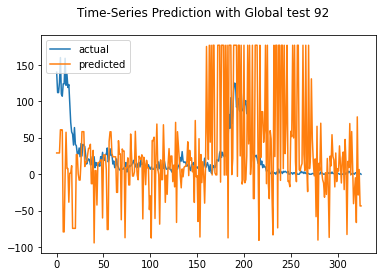

Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
Test MAE: 62.114
Test sMAPE: 146.146
Test RMSE: 84.323
{'mae': 62.114292278611586, 'smape': 146.1460091870048, 'rmse': 84.32286229055481}


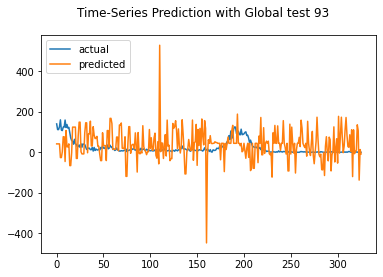

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 48.463
Test sMAPE: 148.352
Test RMSE: 61.574
{'mae': 48.46328019602167, 'smape': 148.3516276828406, 'rmse': 61.57441298398841}


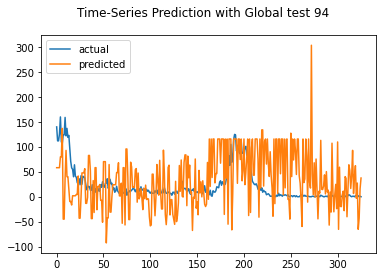

Restoring model weights from the end of the best epoch.
Epoch 00039: early stopping
Test MAE: 33.724
Test sMAPE: 135.211
Test RMSE: 45.295
{'mae': 33.72425051353461, 'smape': 135.21098437779756, 'rmse': 45.29519196090336}


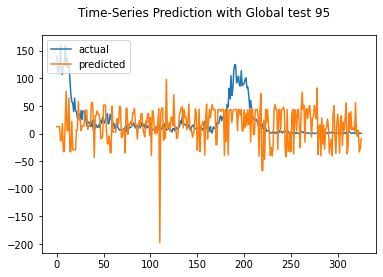

Test MAE: 69.357
Test sMAPE: 135.943
Test RMSE: 85.834
{'mae': 69.35666557908789, 'smape': 135.94316146737143, 'rmse': 85.83359619165583}


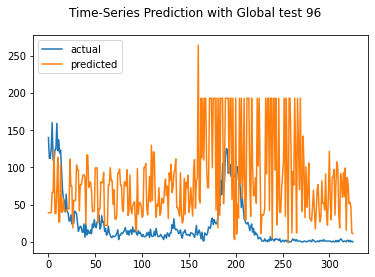

Test MAE: 71.588
Test sMAPE: 138.131
Test RMSE: 86.606
{'mae': 71.5881966710822, 'smape': 138.13063428135624, 'rmse': 86.60600574631837}


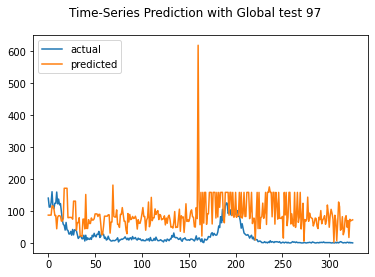

Test MAE: 57.148
Test sMAPE: 140.403
Test RMSE: 66.232
{'mae': 57.1475582607319, 'smape': 140.40312635795584, 'rmse': 66.23241806679997}


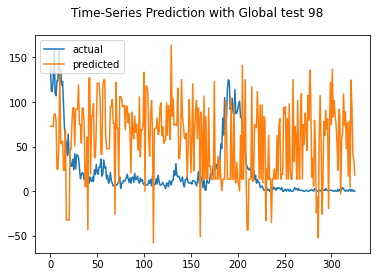

In [ ]:
# Use the Function:
if T != 0: 
    sequence=train_X.shape[1]
    features=train_X.shape[2]
else:
    sequence=T
    features=train_X.shape[1]

calculate_mean_std(lstm_layers, nn_layers, sequence, features, dense_acivation, recurrent_cells, bidirectional, train_X, train_y, test_X, test_y, scalers['scaler_Labels'], monitor=True, plot=False, epochs=50, batch_size=16, n_tests=100, plot_samples=True, Municipality='Global')
